# Spotify Churn Cohort Analysis
This notebook performs:
- Mock churn dataset load
- Initial Feature Engineering
- Basic Cohort retention analysis & Visualization
- Basic Churn patterns by liked songs & Visualization
- Advanced: Granular Cohort Retention (Heatmap)
- Advanced: Survival Analysis (Kaplan-Meier Curves)
- Advanced: Feature Importance for Churn Prediction
- Advanced: Segmentation by Multiple Engagement Metrics
- Advanced: Correlation Matrix of Engagement Metrics
- Suggested growth action based on insights

In [12]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# For Advanced Analysis
from lifelines import KaplanMeierFitter # For Survival Analysis
from sklearn.model_selection import train_test_split # For Feature Importance
from sklearn.ensemble import RandomForestClassifier # For Feature Importance

## Data Loading and Initial Feature Engineering

In [13]:
# Load dataset

df = pd.read_csv('spotify_churn_advanced_mock.csv')

# Convert date columns to datetime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_active_date'] = pd.to_datetime(df['last_active_date'])

# Set a fixed analysis end date for consistent lifetime calculations
analysis_end_date = pd.to_datetime('2025-07-24')

# Calculate effective_last_active_date:
# If user churned (canceled == 1), use their last_active_date.
# If user is still active (canceled == 0), assume they were active up to the analysis_end_date.
df['effective_last_active_date'] = df.apply(lambda row: row['last_active_date'] if row['canceled'] == 1 else analysis_end_date, axis=1)

# Ensure effective_last_active_date is not before signup_date (handle edge cases)
df['effective_last_active_date'] = df.apply(lambda row: max(row['signup_date'], row['effective_last_active_date']), axis=1)

# Calculate user's lifetime in days (duration for survival analysis and cohort periods)
df['lifetime_days'] = (df['effective_last_active_date'] - df['signup_date']).dt.days

# Define 'signup_week' for basic cohort analysis
df['signup_week'] = df['signup_date'].dt.isocalendar().week.astype(int)

# Define 'signup_cohort' in YYYY-WW format for robust cohort identification
df['signup_cohort'] = df['signup_date'].dt.to_period('W').astype(str)

# Define 'is_active' (a simplified proxy for retention at the end of the observation period)
# User is considered 'active' if their recorded 'listening_days' covers most of their 'lifetime_days'
# This is a heuristic: if they listened recently relative to their lifetime duration.
df['is_active'] = df.apply(lambda row: 1 if (row['listening_days'] >= row['lifetime_days'] - 7) else 0, axis=1)

# Define 'liked_songs_group' (Low/High) for basic churn patterns
df['liked_songs_group'] = pd.cut(df['liked_songs'], bins=[-1, 5, 50], labels=['Low','High'], right=False)

print("Initial DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()

Initial DataFrame Head:
  user_id signup_date last_active_date  listening_days  skips  liked_songs  \
0  user_1  2025-05-04       2025-07-24              23     23            8   
1  user_2  2025-07-10       2025-07-24              75     20           47   
2  user_3  2025-07-21       2025-07-24              34     47           26   
3  user_4  2025-06-19       2025-07-24               5     83           33   
4  user_5  2025-06-23       2025-07-24              14    157            7   

   canceled effective_last_active_date  lifetime_days  signup_week  \
0         0                 2025-07-24             81           18   
1         0                 2025-07-24             14           28   
2         0                 2025-07-24              3           30   
3         0                 2025-07-24             35           25   
4         0                 2025-07-24             31           26   

           signup_cohort  is_active liked_songs_group  
0  2025-04-28/2025-05-04      

## Basic Cohort Retention Analysis & Visualization

In [14]:
# Cohort retention calculation
cohort_summary = df.groupby('signup_week').agg(
    total_users=('user_id', 'count'),
    active_users=('is_active', 'sum')
).reset_index()
cohort_summary['retention_rate'] = cohort_summary['active_users'] / cohort_summary['total_users']

print("Weekly Cohort Retention Summary:")
print(cohort_summary)

Weekly Cohort Retention Summary:
    signup_week  total_users  active_users  retention_rate
0            17           12             0        0.000000
1            18           46            19        0.413043
2            19           31             8        0.258065
3            20           45            19        0.422222
4            21           27            17        0.629630
5            22           34            20        0.588235
6            23           35            21        0.600000
7            24           32            19        0.593750
8            25           41            33        0.804878
9            26           51            41        0.803922
10           27           35            31        0.885714
11           28           44            43        0.977273
12           29           48            48        1.000000
13           30           19            19        1.000000


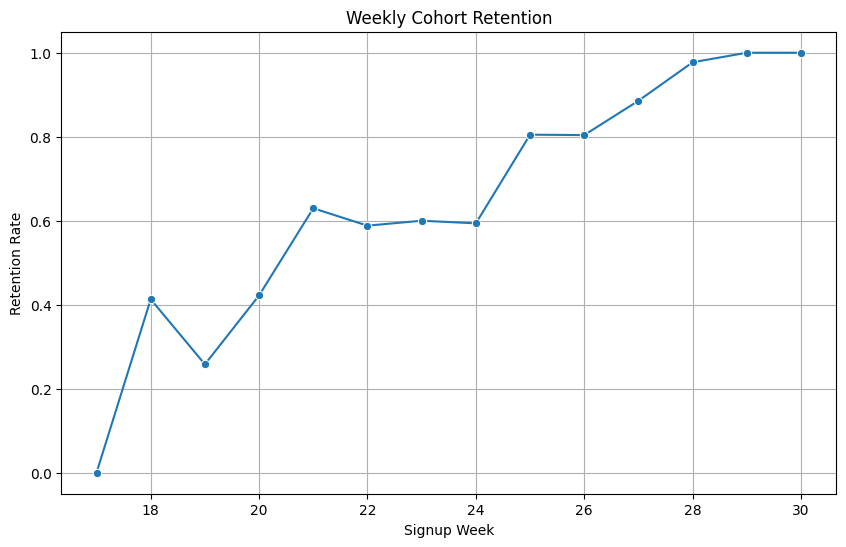

In [15]:
# Plot Weekly Cohort Retention
plt.figure(figsize=(10, 6))
sns.lineplot(data=cohort_summary, x='signup_week', y='retention_rate', marker='o')
plt.title('Weekly Cohort Retention')
plt.ylabel('Retention Rate')
plt.xlabel('Signup Week')
plt.grid(True)
plt.show()

## Basic Churn Patterns by Liked Songs & Visualization

In [16]:
# Churn patterns by liked songs group
churn_by_liked_songs_pattern = df.groupby('liked_songs_group')['canceled'].mean().reset_index()
churn_by_liked_songs_pattern.rename(columns={'canceled': 'churn_rate'}, inplace=True)

print("Churn Rate by Liked Songs Group:")
print(churn_by_liked_songs_pattern)

Churn Rate by Liked Songs Group:
  liked_songs_group  churn_rate
0               Low    0.285714
1              High    0.171111


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17340\21710751.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_liked_songs_pattern = df.groupby('liked_songs_group')['canceled'].mean().reset_index()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17340\722901475.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_liked_songs_pattern, x='liked_songs_group', y='churn_rate', palette='viridis')


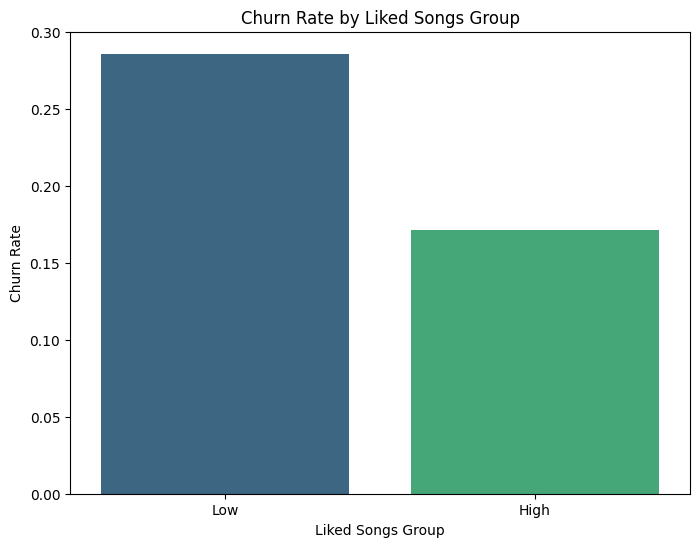

In [17]:
# Visualize Churn Rate by Liked Songs Group
plt.figure(figsize=(8, 6))
sns.barplot(data=churn_by_liked_songs_pattern, x='liked_songs_group', y='churn_rate', palette='viridis')
plt.title('Churn Rate by Liked Songs Group')
plt.ylabel('Churn Rate')
plt.xlabel('Liked Songs Group')
plt.show()

## Advanced Analysis 1: Granular Cohort Retention (Heatmap)

Granular Cohort Retention Data (Pivot Table for Heatmap):
cohort_period           0    1    2         3         4          5     6   \
signup_cohort                                                               
2025-04-28/2025-05-04  1.0  0.0  0.2  0.200000  0.400000   0.000000   0.4   
2025-05-05/2025-05-11  1.0  0.0  1.0  1.000000  0.000000   0.000000   1.0   
2025-05-12/2025-05-18  1.0  0.0  0.0  0.333333  0.333333   0.666667   0.0   
2025-05-26/2025-06-01  1.0  0.0  1.0  1.000000  0.000000   1.000000   0.0   
2025-06-09/2025-06-15  1.0  0.0  2.0  0.000000  0.000000  12.000000  16.0   

cohort_period            7     8         9     10  
signup_cohort                                      
2025-04-28/2025-05-04   0.2   0.2  0.000000   0.0  
2025-05-05/2025-05-11   1.0   0.0  0.000000  13.0  
2025-05-12/2025-05-18   0.0   0.0  6.666667   6.0  
2025-05-26/2025-06-01  14.0  16.0  0.000000   0.0  
2025-06-09/2025-06-15   0.0   0.0  1.000000   0.0  


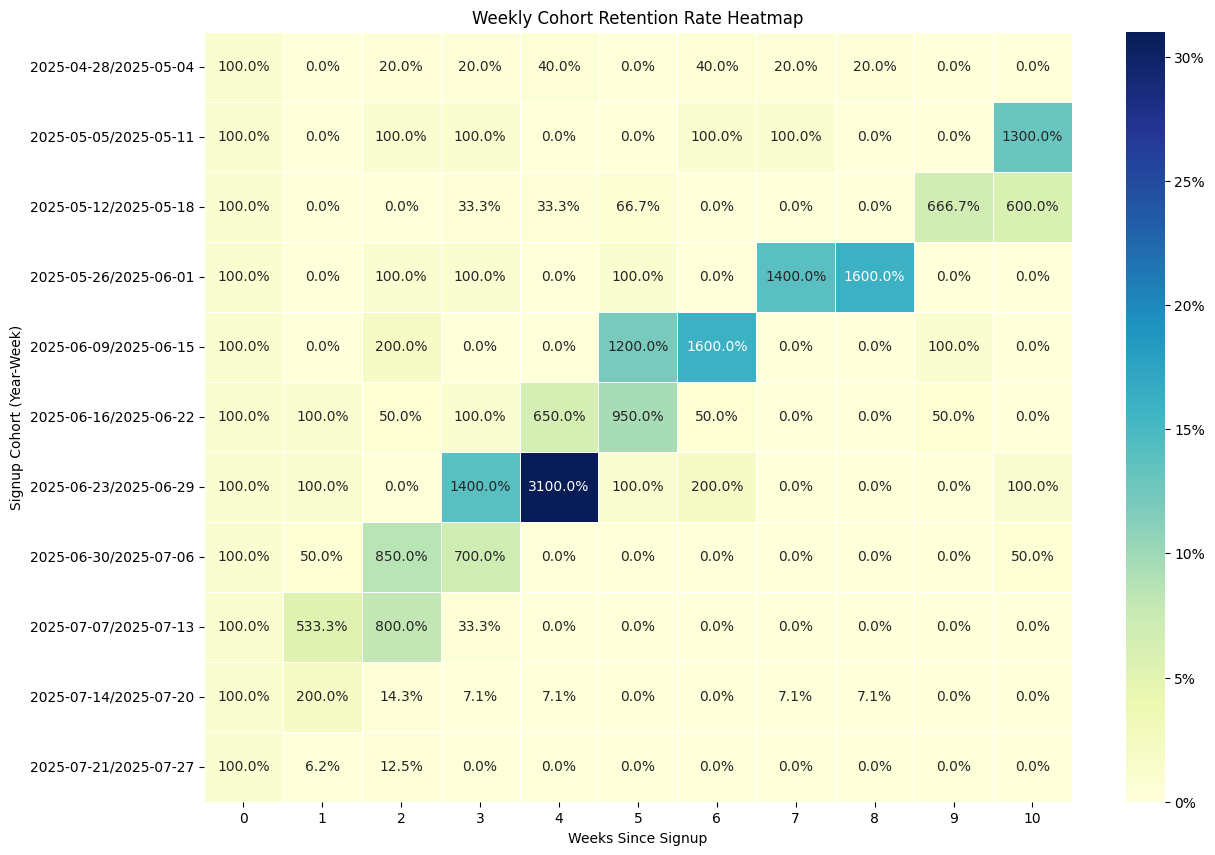

In [18]:
# Calculate the 'cohort_period' (weeks since signup) for each user's lifetime
df['cohort_period'] = (df['lifetime_days'] // 7).astype(int)

# Group by signup_cohort and cohort_period to count users
cohort_counts_granular = df.groupby(['signup_cohort', 'cohort_period'])['user_id'].nunique().reset_index()

# Get the initial cohort size (Week 0 retention)
cohort_sizes_granular = cohort_counts_granular[cohort_counts_granular['cohort_period'] == 0][['signup_cohort', 'user_id']]
cohort_sizes_granular.rename(columns={'user_id': 'cohort_size'}, inplace=True)

# Merge to calculate retention rates
cohort_retention_pivot_df = pd.merge(cohort_counts_granular, cohort_sizes_granular, on='signup_cohort', how='left')
cohort_retention_pivot_df['retention'] = cohort_retention_pivot_df['user_id'] / cohort_retention_pivot_df['cohort_size']

# Create the pivot table for the heatmap
retention_heatmap_data = cohort_retention_pivot_df.pivot_table(
    index='signup_cohort',
    columns='cohort_period',
    values='retention'
).fillna(0) # Fill NaNs (for periods where a cohort doesn't have data) with 0

# Adjust columns to display only relevant periods, e.g., up to 10 weeks for better visualization
max_period_to_show = min(retention_heatmap_data.columns.max(), 10)
retention_heatmap_data = retention_heatmap_data.iloc[:, :max_period_to_show + 1]

print("Granular Cohort Retention Data (Pivot Table for Heatmap):")
print(retention_heatmap_data.head())

# Plot Heatmap of Cohort Retention
plt.figure(figsize=(14, 10))
sns.heatmap(retention_heatmap_data,
            annot=True,    # Show the numerical values
            fmt=".1%",     # Format as percentage with one decimal place
            cmap="YlGnBu", # Color map
            linewidths=.5, # Add lines between cells
            cbar_kws={'format': '%.0f%%'}) # Format color bar as percentage
plt.title('Weekly Cohort Retention Rate Heatmap')
plt.ylabel('Signup Cohort (Year-Week)')
plt.xlabel('Weeks Since Signup')
plt.show()

## Advanced Analysis 2: Survival Analysis (Kaplan-Meier Curves)

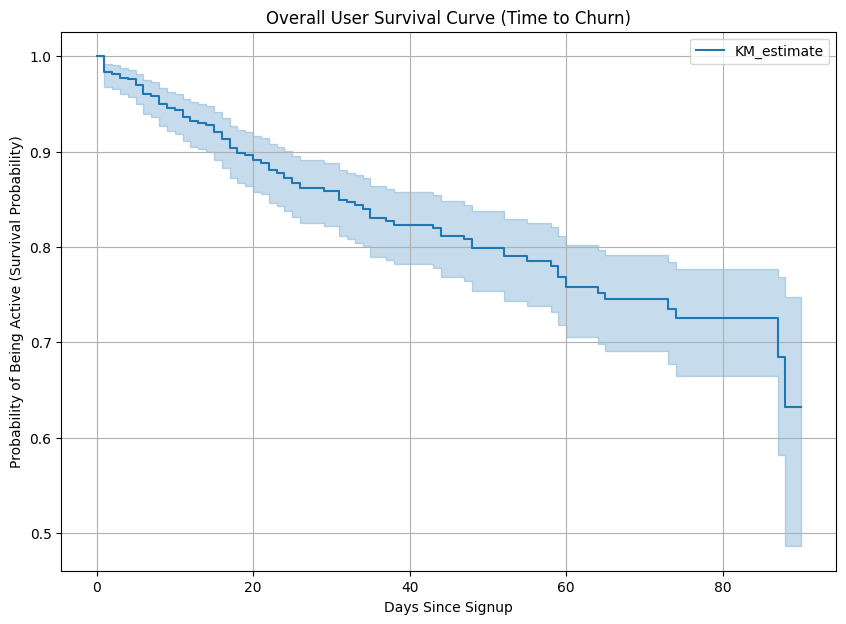

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17340\3205594566.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in df.groupby('liked_songs_group'):


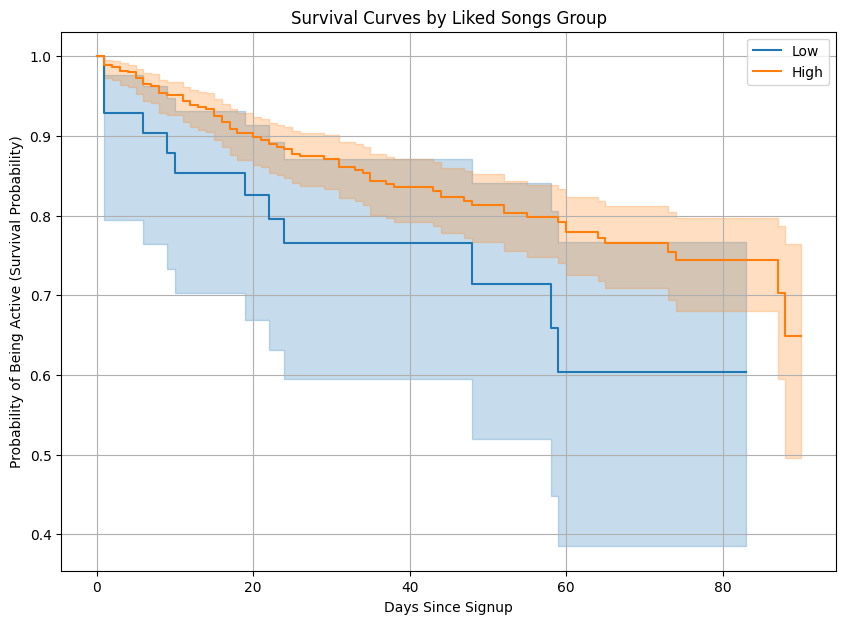

In [19]:
# Define T (duration) and E (event observed)
T = df['lifetime_days'] # Duration until churn or end of observation
E = df['canceled']      # Event observed (1 if churned, 0 if censored)

kmf = KaplanMeierFitter()

# Plot overall survival curve
plt.figure(figsize=(10, 7))
kmf.fit(T, event_observed=E)
kmf.plot_survival_function()
plt.title('Overall User Survival Curve (Time to Churn)')
plt.xlabel('Days Since Signup')
plt.ylabel('Probability of Being Active (Survival Probability)')
plt.grid(True)
plt.show()

# Plot survival curves segmented by 'liked_songs_group'
plt.figure(figsize=(10, 7))
for name, grouped_df in df.groupby('liked_songs_group'):
    # Filter out empty groups if any
    if not grouped_df.empty:
        kmf.fit(grouped_df['lifetime_days'], event_observed=grouped_df['canceled'], label=name)
        kmf.plot_survival_function()

plt.title('Survival Curves by Liked Songs Group')
plt.xlabel('Days Since Signup')
plt.ylabel('Probability of Being Active (Survival Probability)')
plt.grid(True)
plt.show()

## Advanced Analysis 3: Feature Importance for Churn Prediction

Feature Importances for Churn Prediction:
skips             0.392696
listening_days    0.317395
liked_songs       0.289909
dtype: float64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17340\3246529479.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.index, y=feature_importances.values, palette='viridis')


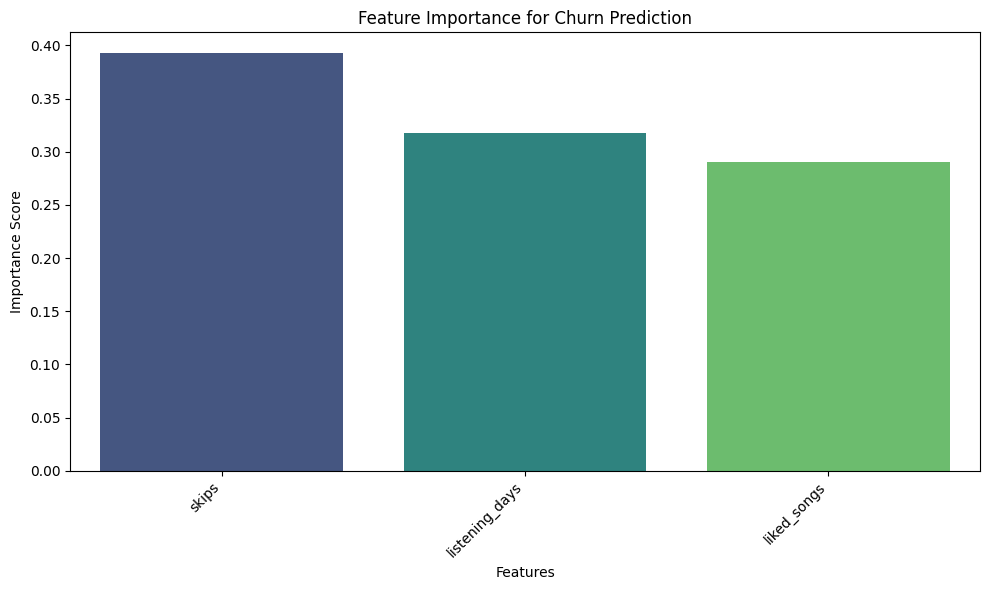

In [20]:
# Select features and target variable
features = ['listening_days', 'skips', 'liked_songs']
target = 'canceled'

X = df[features]
y = df[target]

# Split data into training and testing sets
# stratify=y ensures that the proportion of target variable 'canceled' is the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a RandomForestClassifier (good for feature importance)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

print("Feature Importances for Churn Prediction:")
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances.values, palette='viridis')
plt.title('Feature Importance for Churn Prediction')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Advanced Analysis 4: Segmentation by Multiple Engagement Metrics

Churn Rate by Multi-Feature User Profile:
                         user_profile  churn_rate
17      nan_High Skips_Frequent (>30)    1.000000
13     Low_Low Skips_Infrequent (<10)    1.000000
18     nan_High Skips_Regular (10-30)    1.000000
10    Low_High Skips_Infrequent (<10)    0.500000
20      nan_Low Skips_Regular (10-30)    0.500000
15  Low_Medium Skips_Infrequent (<10)    0.500000
16   Low_Medium Skips_Regular (10-30)    0.428571
9       Low_High Skips_Frequent (>30)    0.333333
12       Low_Low Skips_Frequent (>30)    0.222222
0      High_High Skips_Frequent (>30)    0.213483


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17340\720598796.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_profile, x='user_profile', y='churn_rate', palette='coolwarm')


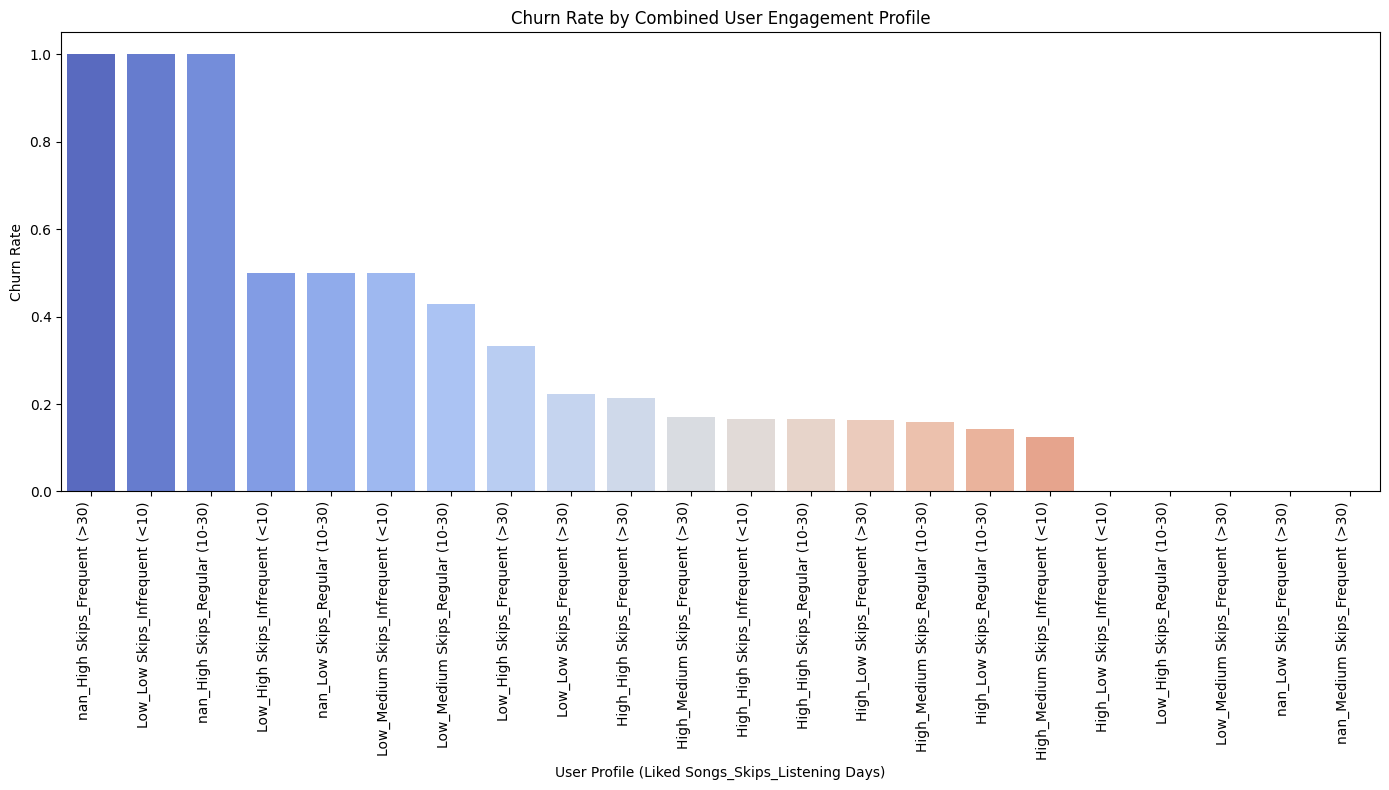

In [21]:
# Create additional segments for 'skips' and 'listening_days'
df['skips_segment'] = pd.cut(df['skips'], bins=[-1, 50, 150, np.inf],
                             labels=['Low Skips', 'Medium Skips', 'High Skips'], right=False)
df['listening_days_segment'] = pd.cut(df['listening_days'], bins=[-1, 10, 30, np.inf],
                                     labels=['Infrequent (<10)', 'Regular (10-30)', 'Frequent (>30)'], right=False)

# Combine segments into a multi-feature user profile string
df['user_profile'] = df['liked_songs_group'].astype(str) + '_' + \
                     df['skips_segment'].astype(str) + '_' + \
                     df['listening_days_segment'].astype(str)

# Calculate churn rate for each new user profile
churn_by_profile = df.groupby('user_profile')['canceled'].mean().reset_index()
churn_by_profile.rename(columns={'canceled': 'churn_rate'}, inplace=True)
churn_by_profile = churn_by_profile.sort_values('churn_rate', ascending=False) # Sort to easily see highest churn profiles

print("Churn Rate by Multi-Feature User Profile:")
print(churn_by_profile.head(10)) # Print top 10 profiles by churn rate

# Visualize Churn Rate by Multi-Feature User Profile
plt.figure(figsize=(14, 8))
sns.barplot(data=churn_by_profile, x='user_profile', y='churn_rate', palette='coolwarm')
plt.title('Churn Rate by Combined User Engagement Profile')
plt.xlabel('User Profile (Liked Songs_Skips_Listening Days)')
plt.ylabel('Churn Rate')
plt.xticks(rotation=90, ha='right') # Rotate labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Advanced Analysis 5: Correlation Matrix of Engagement Metrics


Correlation Matrix of Engagement Features:
                listening_days     skips  liked_songs
listening_days        1.000000 -0.032356    -0.026315
skips                -0.032356  1.000000    -0.061427
liked_songs          -0.026315 -0.061427     1.000000


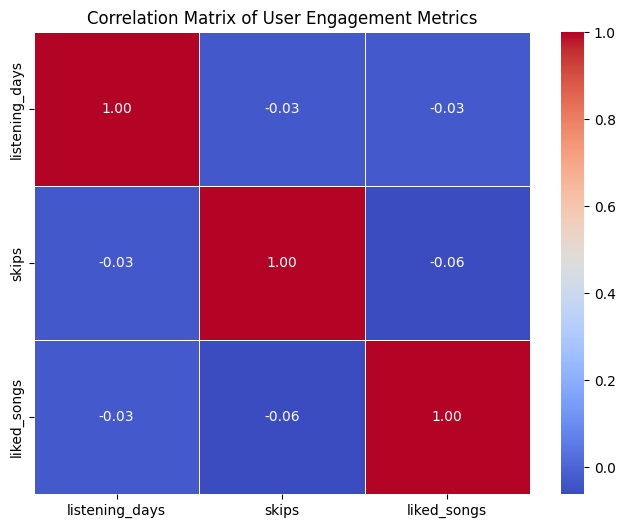

In [22]:
# Select only the numerical engagement features for correlation analysis
engagement_features_for_corr = df[['listening_days', 'skips', 'liked_songs']]

# Calculate the correlation matrix
correlation_matrix = engagement_features_for_corr.corr()

print("\nCorrelation Matrix of Engagement Features:")
print(correlation_matrix)

# Visualize Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True, # Show correlation values on the heatmap
            cmap='coolwarm', # Color map: coolwarm is good for showing positive/negative correlations
            fmt=".2f", # Format annotations to two decimal places
            linewidths=.5) # Add lines between cells for better separation
plt.title('Correlation Matrix of User Engagement Metrics')
plt.show()

### Suggested Action:
Based on the combined insights, particularly the strong influence of 'liked_songs' and the identification of high-churn user profiles:

-   **Targeted Re-engagement Campaigns**: Focus efforts on user segments identified as 'Low Liked Songs', 'High Skips', and 'Infrequent Listeners', as these profiles show the highest churn rates.
-   **Personalized Playlist Push Notifications/Emails**: Send push notifications or emails with highly personalized playlist recommendations to users identified as having 'Low Liked Songs' or 'High Skips'. The goal is to help them discover content they love, encouraging more 'likes' and reducing 'skips'.
    -   *Example Message for Low Liked Songs:* "Hey Aashish! Discover songs you’ll love — tap to save your next favorite from this playlist tailored for you!"
    -   *Example Message for High Skips:* "Finding your perfect beat? Try these curated stations based on your listening history to reduce skips and find your flow!"
-   **Feature Highlighting for Engagement**: In-app prompts or onboarding tours for new users to highlight features like liking songs, creating playlists, or following artists, which are crucial for long-term retention.
-   **A/B Test Engagement Initiatives**: Continuously A/B test different re-engagement strategies (e.g., varying message content, timing, call-to-actions) to optimize their effectiveness and measure their impact on retention rates.